In [1]:
import sae_lens
import torch
import jaxtyping
import random
import datasets
import plotly.colors as pc
import plotly.express as px
import seaborn as sns
import numpy as np
import pandas as pd
from typing import List, Tuple
from tqdm import tqdm

def obtain_data() -> (
    Tuple[List[sae_lens.SAE], torch.nn.Module, torch.utils.data.Dataset]
):
    """
    load sae, model and dataset
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    layers = 6
    saes = []
    release = "pythia-70m-deduped-res-sm"
    model_name = "pythia-70m-deduped"
    for layer in tqdm(range(layers)):
        sae_id = f"blocks.{layer}.hook_resid_post"
        saes.append(
            sae_lens.SAE.from_pretrained(release=release, sae_id=sae_id, device=device)[
                0
            ]
        )

    model = sae_lens.HookedSAETransformer.from_pretrained(model_name)
    ds = datasets.load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")["train"]

    return saes, model, ds

saes, model, ds = obtain_data()

/mnt/c/Users/huohu/Documents/code/SAEGeometry/config/saegeometry-1tp4usyN-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 6/6 [00:03<00:00,  1.51it/s]
The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


Loaded pretrained model pythia-70m-deduped into HookedTransformer


In [24]:
code_acts = torch.load("../res/acts/BAAI-TACO-pythia70m-res-all6-acts.pt")
math_acts = torch.load("../res/acts/math-pythia70m-res-all6-acts.pt")
wiki_acts = torch.load("../res/acts/wiki-pythia70m-res-all6-acts.pt")

top_num = 325
top_index_wiki = torch.topk(wiki_acts, top_num).indices

/tmp/ipykernel_1009/218281768.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  code_acts = torch.load("../res/acts/BAAI-TACO-pythia70m-res-all6-acts.pt")
/tmp/ipykernel_1

In [3]:
len(ds)

36718

In [29]:
import copy
nz_all = []
doc_len = 0
freq_mean_global = 0
layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
freqs = torch.zeros(saes[0].cfg.d_sae).to(device)
abl_layer = 0
abl_times = 10
for layer in range(layers-1):
    nz_freqs = []
    abl_layer = layer
    for idx in tqdm(range(abl_times)):
        saes2 = copy.deepcopy(saes)
        with torch.no_grad():
            abl_num = 29
            list(map(lambda idy: saes2[abl_layer].W_dec[idy, :].zero_(), top_index_wiki[0][abl_num*idx:abl_num*(idx+1)]))
        ds_ratio = 1e-3
        length_ds = int(len(ds) * ds_ratio)
        for idx in range(length_ds):
            # loop begin, fuck indent
            example = ds[idx]
            tokens = model.to_tokens([example["text"]], prepend_bos=True)
            _, cache1 = model.run_with_cache_with_saes(tokens, saes=saes, use_error_term=False)
            model.reset_saes()
            _, cache2 = model.run_with_cache_with_saes(tokens, saes=saes2, use_error_term=False)
            local_doc_len = cache1["blocks.0.hook_resid_post.hook_sae_acts_post"].shape[1]
            freq = torch.zeros_like(freqs)
            
            prompt2 = f"blocks.{abl_layer + 1}.hook_resid_post.hook_sae_acts_post"
            freq = (((cache1[prompt2] > 1e-3) + 0 + cache2[prompt2] > 1e-3)==1)[0].sum(
                0
            ) / local_doc_len
            # freq[layer] = (cache[prompt2] > 1e-3)[0].sum(0) / local_doc_len
            new_doc_len = doc_len + local_doc_len
            if idx == 0:
                freq_mean_global = freq
            else:
                freq_mean_global = (
                    freq_mean_global * doc_len / new_doc_len
                    + freq * local_doc_len / new_doc_len
                )
            doc_len = new_doc_len
        nz_freqs.append(freq_mean_global)
    nz_all.append(nz_freqs)

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


In [30]:
res_ = [[], [], [], [], []]
# TODO: use more top abl, and more datasets, add more group index
for layer in range(layers-1):
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(top_index_wiki[layer+1].cpu().numpy(), (nz_all[layer][idx]>1e-3).nonzero().view(-1).cpu().numpy())
        print(f'common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}')
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_[4]) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (92,) abl_layer: 0 influence freq: torch.Size([8056])
common iou: (64,) abl_layer: 0 influence freq: torch.Size([8113])
common iou: (44,) abl_layer: 0 influence freq: torch.Size([8067])
common iou: (35,) abl_layer: 0 influence freq: torch.Size([8042])
common iou: (33,) abl_layer: 0 influence freq: torch.Size([8054])
common iou: (31,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (26,) abl_layer: 0 influence freq: torch.Size([8053])
common iou: (26,) abl_layer: 0 influence freq: torch.Size([8044])
common iou: (23,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (20,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (45,) abl_layer: 1 influence freq: torch.Size([7008])
common iou: (42,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (41,) abl_layer: 1 influence freq: torch.Size([7011])
common iou: (40,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (40,) abl_layer: 1 influence freq: torch.Size([6999])
common iou

In [32]:
res_ = [[], [], [], [], []]
for layer in range(layers-1):
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(top_index_wiki[layer+1].cpu().numpy(), nz_all[layer][idx].nonzero().view(-1).cpu().numpy())
        print(f'common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}')
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (166,) abl_layer: 0 influence freq: torch.Size([8056])
common iou: (167,) abl_layer: 0 influence freq: torch.Size([8113])
common iou: (167,) abl_layer: 0 influence freq: torch.Size([8067])
common iou: (166,) abl_layer: 0 influence freq: torch.Size([8042])
common iou: (167,) abl_layer: 0 influence freq: torch.Size([8054])
common iou: (166,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (167,) abl_layer: 0 influence freq: torch.Size([8053])
common iou: (166,) abl_layer: 0 influence freq: torch.Size([8044])
common iou: (166,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (166,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (139,) abl_layer: 1 influence freq: torch.Size([7008])
common iou: (138,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (138,) abl_layer: 1 influence freq: torch.Size([7011])
common iou: (138,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (138,) abl_layer: 1 influence freq: torch.Size([69

In [33]:
import copy
nz_all = []
top_num = 600
top_index_wiki = torch.topk(wiki_acts, top_num).indices
doc_len = 0
freq_mean_global = 0
layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
freqs = torch.zeros(saes[0].cfg.d_sae).to(device)
abl_layer = 0
abl_times = 19
for layer in range(layers-1):
    nz_freqs = []
    abl_layer = layer
    for idx in tqdm(range(abl_times)):
        saes2 = copy.deepcopy(saes)
        with torch.no_grad():
            abl_num = 29
            list(map(lambda idy: saes2[abl_layer].W_dec[idy, :].zero_(), top_index_wiki[0][abl_num*idx:abl_num*(idx+1)]))
        ds_ratio = 1e-3
        length_ds = int(len(ds) * ds_ratio)
        for idx in range(length_ds):
            # loop begin, fuck indent
            example = ds[idx]
            tokens = model.to_tokens([example["text"]], prepend_bos=True)
            _, cache1 = model.run_with_cache_with_saes(tokens, saes=saes, use_error_term=False)
            model.reset_saes()
            _, cache2 = model.run_with_cache_with_saes(tokens, saes=saes2, use_error_term=False)
            local_doc_len = cache1["blocks.0.hook_resid_post.hook_sae_acts_post"].shape[1]
            freq = torch.zeros_like(freqs)
            
            prompt2 = f"blocks.{abl_layer + 1}.hook_resid_post.hook_sae_acts_post"
            freq = (((cache1[prompt2] > 1e-3) + 0 + cache2[prompt2] > 1e-3)==1)[0].sum(
                0
            ) / local_doc_len
            # freq[layer] = (cache[prompt2] > 1e-3)[0].sum(0) / local_doc_len
            new_doc_len = doc_len + local_doc_len
            if idx == 0:
                freq_mean_global = freq
            else:
                freq_mean_global = (
                    freq_mean_global * doc_len / new_doc_len
                    + freq * local_doc_len / new_doc_len
                )
            doc_len = new_doc_len
        nz_freqs.append(freq_mean_global)
    nz_all.append(nz_freqs)

100%|██████████| 19/19 [00:24<00:00,  1.31s/it]


In [45]:
top_index_wiki = torch.topk(wiki_acts, top_num).indices

res_ = [[], [], [], [], []]
for layer in range(layers-1):
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(top_index_wiki[layer+2].cpu().numpy(), nz_all[layer][idx].nonzero().view(-1).cpu().numpy())
        print(f'common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}')
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (324,) abl_layer: 0 influence freq: torch.Size([8056])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8113])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8067])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8042])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8054])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8053])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8044])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8048])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8106])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([80

In [49]:
res_ = [[], [], [], [], []]
top_num = 325
top_index_wiki = torch.topk(wiki_acts, top_num).indices

# TODO: use more top abl, and more datasets, add more group index
for layer in range(layers-1):
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(top_index_wiki[layer+2].cpu().numpy(), (nz_all[layer][idx]>1e-3).nonzero().view(-1).cpu().numpy())
        print(f'common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}')
        res_[layer].append(res)

last_iou = res_[4][0]
for idx in range(len(res_[4]) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (324,) abl_layer: 0 influence freq: torch.Size([8056])
common iou: (324,) abl_layer: 0 influence freq: torch.Size([8113])
common iou: (322,) abl_layer: 0 influence freq: torch.Size([8067])
common iou: (321,) abl_layer: 0 influence freq: torch.Size([8042])
common iou: (320,) abl_layer: 0 influence freq: torch.Size([8054])
common iou: (316,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (312,) abl_layer: 0 influence freq: torch.Size([8053])
common iou: (305,) abl_layer: 0 influence freq: torch.Size([8044])
common iou: (301,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (297,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (296,) abl_layer: 0 influence freq: torch.Size([8048])
common iou: (293,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (289,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (287,) abl_layer: 0 influence freq: torch.Size([8106])
common iou: (282,) abl_layer: 0 influence freq: torch.Size([80

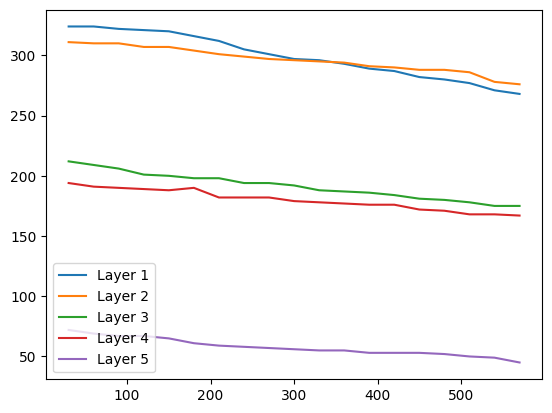

In [52]:
import matplotlib.pyplot as plt
import numpy as np
res_shape = [[], [], [], [], []]
for layer in range(5):
    for idx in range(len(res_[layer])):
        res_shape[layer].append(res_[layer][idx].shape)
for layer in range(5):
    plt.plot(np.arange(30, 600, 30), res_shape[layer], label=f"Layer {layer+1}")
plt.legend()
# plt.title('common feature influence(>1e-3) on high freq vector')
plt.show()
# plt.savefig("../../res/ablation/abl_low_high_perb_math_pythia_common_res_post.png")

In [39]:
res_ = [[], [], [], [], []]
for layer in range(5):
    top_index_code = torch.topk(code_acts[layer+1], 325).indices
    top_index_math = torch.topk(math_acts[layer+2], 325).indices
    top_index_wiki = torch.topk(wiki_acts[layer+2], 325).indices
    top_index_mc = np.intersect1d(top_index_code.cpu().numpy(), top_index_math.cpu().numpy())
    top_index_mw = np.intersect1d(top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index_cw = np.intersect1d(top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw))
    top_index_math = np.setdiff1d(top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw))
    top_index_code = np.setdiff1d(top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw))
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    res_ = [[], [], [], [], []]
    # TODO: use more top abl, and more datasets, add more group index
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(top_index_wiki, (nz_all[layer][idx]>1e-3).nonzero().view(-1).cpu().numpy())
        print(f'common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}')
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_[4]) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (94,) abl_layer: 0 influence freq: torch.Size([8056])
common iou: (94,) abl_layer: 0 influence freq: torch.Size([8113])
common iou: (94,) abl_layer: 0 influence freq: torch.Size([8067])
common iou: (94,) abl_layer: 0 influence freq: torch.Size([8042])
common iou: (93,) abl_layer: 0 influence freq: torch.Size([8054])
common iou: (93,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (92,) abl_layer: 0 influence freq: torch.Size([8053])
common iou: (92,) abl_layer: 0 influence freq: torch.Size([8044])
common iou: (91,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (91,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (91,) abl_layer: 0 influence freq: torch.Size([8048])
common iou: (90,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (89,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (89,) abl_layer: 0 influence freq: torch.Size([8106])
common iou: (87,) abl_layer: 0 influence freq: torch.Size([8042])
common iou

In [40]:
res_ = [[], [], [], [], []]
for layer in range(5):
    top_index_code = torch.topk(code_acts[layer+1], 325).indices
    top_index_math = torch.topk(math_acts[layer+2], 325).indices
    top_index_wiki = torch.topk(wiki_acts[layer+2], 325).indices
    top_index_mc = np.intersect1d(top_index_code.cpu().numpy(), top_index_math.cpu().numpy())
    top_index_mw = np.intersect1d(top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index_cw = np.intersect1d(top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw))
    top_index_math = np.setdiff1d(top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw))
    top_index_code = np.setdiff1d(top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw))
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    res_ = [[], [], [], [], []]
    # TODO: use more top abl, and more datasets, add more group index
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(top_index, (nz_all[layer][idx]>1e-3).nonzero().view(-1).cpu().numpy())
        print(f'common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}')
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_[4]) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (25,) abl_layer: 0 influence freq: torch.Size([8056])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8113])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8067])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8042])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8054])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8053])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8044])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8045])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8048])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8106])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8042])
common iou

In [53]:
import copy
nz_all = []
top_num = 600
top_index_wiki = torch.topk(wiki_acts, top_num).indices
doc_len = 0
freq_mean_global = 0
layers = 6
device = "cuda" if torch.cuda.is_available() else "cpu"
freqs = torch.zeros(saes[0].cfg.d_sae).to(device)
abl_layer = 0
abl_times = 10
for layer in range(layers-1):
    nz_freqs = []
    abl_layer = layer
    top_index_code = torch.topk(code_acts[layer+1], 600).indices
    top_index_math = torch.topk(math_acts[layer+2], 600).indices
    top_index_wiki = torch.topk(wiki_acts[layer+2], 600).indices
    top_index_mc = np.intersect1d(top_index_code.cpu().numpy(), top_index_math.cpu().numpy())
    top_index_mw = np.intersect1d(top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index_cw = np.intersect1d(top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw))
    top_index_math = np.setdiff1d(top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw))
    top_index_code = np.setdiff1d(top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw))
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    for idx in tqdm(range(abl_times)):
        saes2 = copy.deepcopy(saes)
        with torch.no_grad():
            abl_num = 29
            list(map(lambda idy: saes2[abl_layer].W_dec[idy, :].zero_(), top_index_wiki[abl_num*idx:abl_num*(idx+1)]))
        ds_ratio = 1e-3
        length_ds = int(len(ds) * ds_ratio)
        for idx in range(length_ds):
            # loop begin, fuck indent
            example = ds[idx]
            tokens = model.to_tokens([example["text"]], prepend_bos=True)
            _, cache1 = model.run_with_cache_with_saes(tokens, saes=saes, use_error_term=False)
            model.reset_saes()
            _, cache2 = model.run_with_cache_with_saes(tokens, saes=saes2, use_error_term=False)
            local_doc_len = cache1["blocks.0.hook_resid_post.hook_sae_acts_post"].shape[1]
            freq = torch.zeros_like(freqs)
            
            prompt2 = f"blocks.{abl_layer + 1}.hook_resid_post.hook_sae_acts_post"
            freq = (((cache1[prompt2] > 1e-3) + 0 + cache2[prompt2] > 1e-3)==1)[0].sum(
                0
            ) / local_doc_len
            # freq[layer] = (cache[prompt2] > 1e-3)[0].sum(0) / local_doc_len
            new_doc_len = doc_len + local_doc_len
            if idx == 0:
                freq_mean_global = freq
            else:
                freq_mean_global = (
                    freq_mean_global * doc_len / new_doc_len
                    + freq * local_doc_len / new_doc_len
                )
            doc_len = new_doc_len
        nz_freqs.append(freq_mean_global)
    nz_all.append(nz_freqs)

100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


In [57]:
res_ = [[], [], [], [], []]
for layer in range(5):
    top_index_code = torch.topk(code_acts[layer+1], 325).indices
    top_index_math = torch.topk(math_acts[layer+2], 325).indices
    top_index_wiki = torch.topk(wiki_acts[layer+2], 325).indices
    top_index_mc = np.intersect1d(top_index_code.cpu().numpy(), top_index_math.cpu().numpy())
    top_index_mw = np.intersect1d(top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index_cw = np.intersect1d(top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw))
    top_index_math = np.setdiff1d(top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw))
    top_index_code = np.setdiff1d(top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw))
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    res_ = [[], [], [], [], []]
    # TODO: use more top abl, and more datasets, add more group index
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(top_index_wiki, (nz_all[layer][idx]>1e-1).nonzero().view(-1).cpu().numpy())
        print(f'common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}')
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_[4]) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (12,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (4,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8059])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8049])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8084])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8049])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (2,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (0,) abl_layer: 1 influence freq: torch.Size([7002])
common iou: (0,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (0,) abl_layer: 1 influence freq: torch.Size([6999])
common iou: (0,) abl_layer: 1 influence freq: torch.Size([7000])
common iou: (0,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (0,) abl_lay

In [55]:
res_ = [[], [], [], [], []]
for layer in range(5):
    top_index_code = torch.topk(code_acts[layer+1], 325).indices
    top_index_math = torch.topk(math_acts[layer+2], 325).indices
    top_index_wiki = torch.topk(wiki_acts[layer+2], 325).indices
    top_index_mc = np.intersect1d(top_index_code.cpu().numpy(), top_index_math.cpu().numpy())
    top_index_mw = np.intersect1d(top_index_math.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index_cw = np.intersect1d(top_index_code.cpu().numpy(), top_index_wiki.cpu().numpy())
    top_index = np.intersect1d(top_index_mc, top_index_mw)
    top_index_wiki = np.setdiff1d(top_index_wiki.cpu().numpy(), np.union1d(top_index_cw, top_index_mw))
    top_index_math = np.setdiff1d(top_index_math.cpu().numpy(), np.union1d(top_index_mc, top_index_mw))
    top_index_code = np.setdiff1d(top_index_code.cpu().numpy(), np.union1d(top_index_mc, top_index_cw))
    top_index_mc = np.setdiff1d(top_index_mc, top_index)
    top_index_mw = np.setdiff1d(top_index_mw, top_index)
    top_index_cw = np.setdiff1d(top_index_cw, top_index)
    res_ = [[], [], [], [], []]
    # TODO: use more top abl, and more datasets, add more group index
    for idx in range(len(nz_freqs)):
        res = np.intersect1d(top_index, (nz_all[layer][idx]>1e-3).nonzero().view(-1).cpu().numpy())
        print(f'common iou: {res.shape} abl_layer: {layer} influence freq: {nz_all[layer][idx].nonzero().view(-1).shape}')
        res_[layer].append(res)
last_iou = res_[4][0]
for idx in range(len(res_[4]) - 1):
    iou = np.intersect1d(last_iou, res_[4][idx])
    last_iou = iou
    print(f"iou with last abl: {iou.shape}")

common iou: (25,) abl_layer: 0 influence freq: torch.Size([8043])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8047])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8059])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8049])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8084])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8049])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8046])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (25,) abl_layer: 0 influence freq: torch.Size([8041])
common iou: (7,) abl_layer: 1 influence freq: torch.Size([7002])
common iou: (7,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (7,) abl_layer: 1 influence freq: torch.Size([6999])
common iou: (7,) abl_layer: 1 influence freq: torch.Size([7000])
common iou: (7,) abl_layer: 1 influence freq: torch.Size([7004])
common iou: (7,